In [68]:
from qiime2.plugins import feature_table
from qiime2.plugins import diversity
from qiime2 import Artifact
import pandas as pd
import biom
from qiime2.plugins import diversity
from skbio import TreeNode
import gneiss
from gneiss.sort import niche_sort
from skbio.stats.composition import ilr_inv
from gneiss.balances import balance_basis
import qiime2
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
# Written by JG 2/6/18


# Outline of importing existing biom table, tree and other stuff to Q2

# 1. import biom table using qiime tools import
# 1b. feature table options - frequency and relativefrequency. note that frequency is absolute. kinda dumb name.
# 2. Filter the "frequency table" based on sample names, min sample observation #, and min OTU count.
# 3. 

In [90]:
# Path names for artifacts. At the moment I'm just line magicking everything, 
# at somepoint I'll try to get the artifact API working.

# Initial biom table and filtering output
biom_path = '../Seq_data/vsearch/biom_table_w_tax.biom'
artifact_path = '../Seq_data/qiime2/full_feature_table2.qza'
feature_table_mc100 = '../Seq_data/qiime2/feature_table_mc100.qza'
feature_table_mc200 = '../Seq_data/qiime2/feature_table_mc200.qza'
feature_table_no_w11_mc200 = '../Seq_data/qiime2/feature_table_ms2500_mc200.qza'
ft_no_w11 = '../Seq_data/qiime2/ft_no_w11.qza'

# Gneiss specific paths
clustered = '../Seq_data/qiime2/clustered_otus.qza'  # A hierarchical tree
pseudocounts = '../Seq_data/qiime2/ft_w_pseudocounts.qza'
balances = '../Seq_data/qiime2/ward_balances.qza'
regression_summary = '../Seq_data/qiime2/regression_summary.qzv'
regression_summary_fixed_well = '../Seq_data/qiime2/regression_summary_fixed_well.qzv'


# ph gradient clustering approach:

ph_tree = '../Seq_data/qiime2/ph_tree.nwk.qza'
ph_tree_grad_cluster = '../Seq_data/qiime2/ph_tree_gradcluster.nwk.qza'
ph_balances = '../Seq_data/qiime2/ph_balances.qza'
ph_clustered = '../Seq_data/qiime2/ph_clustered.qza'
regression_summary_grad_cluster = '../Seq_data/qiime2/regression_summary_ph_cluster'
#
map_file = '../Metadata/Metadata-IBP_3.txt'
map_file = '../Metadata/ibp_metadata_2.6.18_normalized.txt'

In [89]:
# 2/7/18 Attempting to fix gradient clustering

!qiime gneiss gradient-clustering \
    --i-table  $feature_table_no_w11_mc200 \
    --m-gradient-file $map_file \
    --m-gradient-category pH \
    --o-clustering $ph_tree_grad_cluster \
    --p-no-weighted

!qiime gneiss ilr-transform --i-table $pseudocounts --i-tree $ph_tree_grad_cluster --o-balances $ph_balances


Saved Hierarchy to: ../Seq_data/qiime2/ph_tree_gradcluster.nwk.qza
Saved FeatureTable[Balance] to: ../Seq_data/qiime2/ph_balances.qza


In [91]:
!qiime gneiss ols-regression --p-formula "pH" \
     --i-tree $ph_tree_grad_cluster --i-table $ph_balances --m-metadata-file $map_file --o-visualization $regression_summary_ph_only

Saved Visualization to: ../Seq_data/qiime2/regression_summary_ph_cluster.qzv


In [10]:
# Using ipython magic commands, we can run qiime import and feature-table manipulation commands:

# Import feature table
#!qiime tools import --input-path $biom_path --type 'FeatureTable[Frequency]' --source-format BIOMV210Format --output-path $artifact_path


# Remove samples matching WLW11 and total counts < 2500.
!qiime feature-table filter-samples --i-table $artifact_path --p-min-frequency 2500 --m-metadata-file $map_file --o-filtered-table $ft_no_w11  


# Remove OTUs with <100 counts
!qiime feature-table filter-features --i-table $ft_no_w11 --p-min-frequency 200 --o-filtered-table $feature_table_no_w11_mc200


Saved FeatureTable[Frequency] to: ../Seq_data/qiime2/ft_no_w11.qza
Saved FeatureTable[Frequency] to: ../Seq_data/qiime2/feature_table_ms2500_mc200.qza


In [11]:
# Gneiss workflow:
!qiime composition add-pseudocount --i-table $feature_table_no_w11_mc200 --p-pseudocount 1 --o-composition-table $pseudocounts
print('starting clustering')
!qiime gneiss -clustering --i-table $pseudocounts --o-clustering $clustered

#Predicting balances from metadata:
!qiime gneiss ilr-transform --i-table $pseudocounts --i-tree $clustered --o-balances $balances


Saved FeatureTable[Composition] to: ../Seq_data/qiime2/ft_w_pseudocounts.qza
starting clustering
Saved Hierarchy to: ../Seq_data/qiime2/clustered_otus.qza
Saved FeatureTable[Balance] to: ../Seq_data/qiime2/balances.qza


In [51]:
# Ordinary Least Squares Regression:
## Need to fix the formula. Also... the regression variables need to be normalized to be comparable.
!qiime gneiss ols-regression --p-formula "pH + cum_depth + WLWNum + inundation_fraction" \
     --i-tree $clustered --i-table $balances --m-metadata-file $map_file --o-visualization $regression_summary_fixed_well

Saved Visualization to: ../Seq_data/qiime2/regression_summary_fixed_well.qzv


In [23]:
# The OLS regression in gneiss is slow as fuck, I'm going to send my data to R and use glmnet as one option.
# The other thing I need to do is figure out how I'm going to visualize some relatively simple stuff 
# (i.e. redo the pH effect shown in the paper. 

In [ ]:
# pH (and depth or inundation plotting)

pseudocount_table = Artifact.load(pseudocounts)
mapdf = pd.read_csv(map_file, sep='\t')
pH = mapdf['pH']

print(len(pseudocount_table))
print(len(pH))

# I probably need to do a bit of tinkering to get those to line up

#gneiss.cluster.gradient_linkage()

In [ ]:
# following along with the example in the gneiss paper:


# 2. generate a heatmap of observed OTU abundances for samples ordered by a gradient:
!qiime gneiss dendrogram-heatmap \
    --i-table 88soils_composition.biom.qza \
    --i-tree ph_tree.nwk.qza \
    --m-metadata-file 88soils_rounded_metadata.txt \
    --m-metadata-category "ph_rounded" \
    --o-visualization "ph_heatmap" \
    --p-ndim 10 --verbose

# 3.   ILR transform samples
    !qiime gneiss ilr-transform \
    --i-table 88soils_composition.biom.qza \
    --i-tree ph_tree.nwk.qza \
    --o-balances 88soils_balances.qza
    
# 4. They used a 4th degree polynomial transformation of pH at some point but I thought they were plotting samples along one axis...


In [54]:
# 1. gradient cluster along ph:
!qiime gneiss gradient-clustering \
    --i-table $feature_table_no_w11_mc200 \
    --m-gradient-file $map_file \
    --m-gradient-category pH \
    --o-clustering $ph_tree \
    --p-no-weighted
    

Saved Hierarchy to: ../Seq_data/qiime2/ph_tree.nwk.qza


In [93]:
# Load all of my objects into python:
table_art = Artifact.load(feature_table_no_w11_mc200)
table = table_art.view(pd.DataFrame)
metadata = pd.read_csv(map_file, sep='\t', index_col='#SampleID')

print('sorting table')
observed_table = niche_sort(table, metadata['pH'])

tree_art = Artifact.load(ph_tree_grad_cluster)
tree = tree_art.view(TreeNode)

print('importing visualization')
viz = qiime2.Visualization.load('../Seq_data/qiime2/regression_summary_ph_cluster.qzv')
viz.export_data('../Seq_data/qiime2/regression_summary_grad_cluster')
predicted_balances = pd.read_csv('../Seq_data/qiime2/regression_summary_grad_cluster/predicted.csv', index_col=0)

sorting table
importing visualization


In [94]:
# Predict OTU abundances from balances:
basis, nodes = balance_basis(tree)
ids = [n.name for n in tree.tips()]

predicted_table = ilr_inv(predicted_balances.T, basis)
predicted_table = pd.DataFrame(predicted_table, columns=ids, 
                               index=predicted_balances.columns)
predicted_table = predicted_table.reindex(index=observed_table.index,
                                          columns=observed_table.columns)

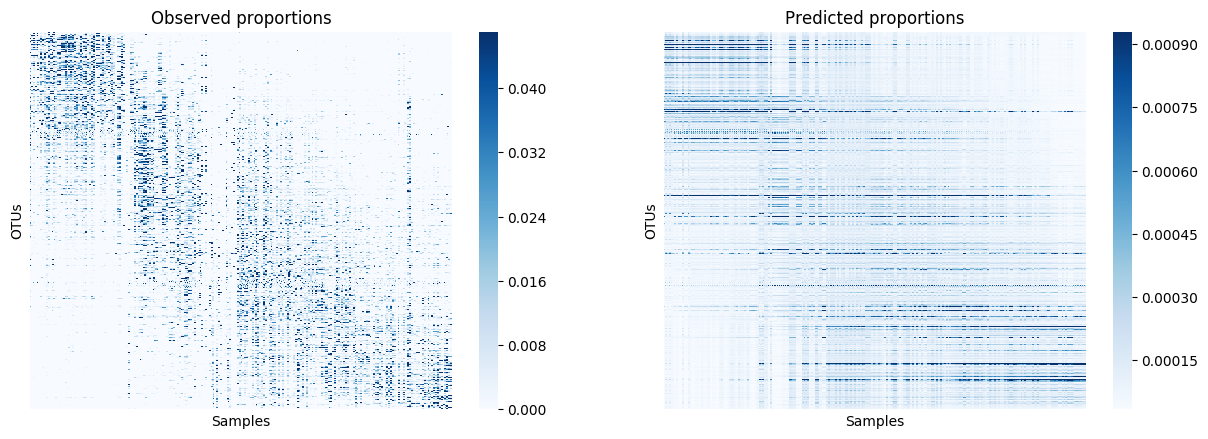

In [98]:
### from skbio.stats.composition import closure
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
sns.heatmap(closure(observed_table.T), robust=True, ax=ax1, cmap='Blues')
sns.heatmap(predicted_table.T, robust=True, ax=ax2, cmap='Blues')
ax1.set_title('Observed proportions')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_xlabel('Samples')
ax1.set_ylabel('OTUs')
ax2.set_title('Predicted proportions')
ax2.set_xlabel('Samples')
ax2.set_ylabel('OTUs')
fig.savefig('../output/predicted_vs_observed_4factor_model.png')

In [73]:
# Sorting the observed table by pH works pretty well. 
# The predicted balances did not work at all however.

#SampleID
W9.D1.rB      1.386837e-16
W8.D11.rB     1.025092e-07
W8.D8.rB      2.637680e-10
W8.D11.rA     1.025092e-07
W8.D8.rA      2.637680e-10
W9.D8.rA      2.919534e-10
W7.D2.rB      9.150773e-16
W9.D8.rB      2.919534e-10
W7.D2.rA      9.150773e-16
W9.D1.rA      1.386837e-16
W8.D10.rA     2.742696e-08
W9.D2.rA      9.518597e-15
W9.D2.rB      9.518597e-15
W8.D10.rB     2.742696e-08
W8.D7.rB      7.218244e-11
W7.D3.rA      7.769965e-14
W7.D3.rB      7.769965e-14
W8.D5.rB      2.238453e-12
W8.D5.rA      2.238453e-12
W9.D4.rA      5.690978e-13
W8.D7.rA      7.218244e-11
W9.D5.rB      3.551572e-12
W9.D4.rB      5.690978e-13
W9.D5.rA      3.551572e-12
W9.D7.rA      1.100065e-10
W7.D1.rB      8.130709e-17
W7.D4.rB      7.364048e-13
W8.D4.rA      4.374555e-13
W7.D1.rA      8.130709e-17
W8.D2.rB      1.255134e-14
                  ...     
W4.D8.A       3.119145e-12
W10.D9.rB     9.234170e-08
W3.D10.A      4.641621e-09
W3.D10.rB     4.641621e-09
W10.D9.rA     9.234170e-08
W3.D9.A       4.97

In [75]:
tree

<TreeNode, name: y0, internal node count: 4903, tips count: 4905>

In [86]:
# Potential options here:
# 1. I need to gradient cluster before I make balances?

,W1.D10.rB,W3.D11.rB,W1.D6.A,W3.D8.rB,W1.D12.A,W8.D7.rA,W3.D4.rB,W10.D7.rA,W3.D11.A,W5.D2.rB,...,W2.D12.rB,W5.D8.rB,W7.D11.rA,W1.D7.A,W6.D7.A,W3.D7.A,W5.D10.A,W9.D11.rA,W6.D7.rB,W10.D5.rA
y0,-33.674956,-36.229669,-11.996241,-24.725854,-43.234965,18.202304,-6.480733,-16.612377,-36.229669,11.048718,...,-41.025116,-22.267995,-7.854956,-7.974555,-4.240000,-6.480733,-27.399452,2.080368,-4.240000,-7.895350
y1,17.450104,17.744389,18.405878,18.850716,19.225408,3.883627,13.168558,20.036405,17.744389,13.411617,...,18.359815,16.777351,4.470955,13.382652,12.847418,13.168558,15.539848,-0.326936,12.847418,19.811918
y2,17.463048,12.359446,11.714495,18.410976,14.282662,-20.217037,7.076914,5.703873,12.359446,14.175943,...,11.853606,14.993483,-8.423877,10.142090,2.479151,7.076914,9.950647,-17.249395,2.479151,6.205065
y3,-8.347322,-8.882643,-3.915906,-5.806604,-10.498515,0.209760,-3.201531,-3.547245,-8.882643,1.554281,...,-10.093818,-5.356680,-4.770205,-3.652100,-2.525677,-3.201531,-6.974453,-3.348006,-2.525677,-1.621076
y4,1.943053,4.131865,-2.973633,1.511194,3.482064,0.028960,-1.119666,5.596716,4.131865,-2.991168,...,4.089847,3.248762,4.684096,-2.606885,1.111164,-1.119666,4.566632,5.429905,1.111164,3.812518
y5,-4.590776,-4.050071,3.880162,-2.470125,-6.144414,19.921866,5.912148,2.818490,-4.050071,8.401283,...,-5.015642,-1.317146,8.579201,4.907964,7.418426,5.912148,-1.351896,13.364676,7.418426,5.215386
y6,-10.127432,-14.313970,-5.668000,-7.824620,-18.277730,9.858955,1.451137,-12.862278,-14.313970,12.256599,...,-17.453141,-5.720218,4.705545,2.149382,0.403770,1.451137,-8.852457,10.748671,0.403770,-8.685815
y7,7.196670,7.437409,4.839305,6.855184,8.004051,-0.088166,3.951896,6.464247,7.437409,3.143929,...,7.732039,6.569040,3.042218,3.987824,3.898006,3.951896,6.613553,1.484945,3.898006,5.665069
y8,2.667824,0.614138,4.982422,1.084538,2.364215,0.683617,3.005361,-5.203855,0.614138,1.440606,...,1.506659,-0.946321,-1.204409,4.969499,0.059154,3.005361,-1.016321,-2.416923,0.059154,-4.581776
y9,2.106057,1.913180,2.640379,2.267714,1.905629,2.373024,2.478870,2.050252,1.913180,2.852915,...,1.865004,2.135483,1.867357,2.575337,2.334169,2.478870,1.940772,1.804999,2.334169,2.262424


In [ ]:
!qiime gneiss balance-taxonomy \
    --i-balances 88soils_balances.qza \
    --i-tree ph_tree.nwk.qza \
    --i-taxonomy 88soils_taxonomy.qza \
    --p-taxa-level 2 \
    --p-balance-name 'y0' \
    --m-metadata-file '88soils_modified_metadata.txt' \
    --m-metadata-category 'ph' \
    --o-visualization y0_taxa_summary.qzv